In [1]:
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.aep_models as aep
import geepee.ep_models as ep
%matplotlib inline
np.random.seed(42)
import pdb

In [2]:
# We first define several utility functions

def kink_true(x):
    fx = np.zeros(x.shape)
    for t in range(x.shape[0]):
        xt = x[t]
        if xt < 4:
            fx[t] = xt + 1
        else:
            fx[t] = -4*xt + 21
    return fx


def kink(T, process_noise, obs_noise, xprev=None):
    if xprev is None:
        xprev = np.random.randn()
    y = np.zeros([T, ])
    x = np.zeros([T, ])
    xtrue = np.zeros([T, ])
    for t in range(T):
        if xprev < 4:
            fx = xprev + 1
        else:
            fx = -4*xprev + 21

        xtrue[t] = fx
        x[t] = fx + np.sqrt(process_noise)*np.random.randn()
        xprev = x[t]
        y[t] = x[t] + np.sqrt(obs_noise)*np.random.randn()

    return xtrue, x, y


def plot(model):
    # make prediction on some test inputs
    N_test = 200
    x_test = np.linspace(-4, 6, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    zu = model.sgp_layer.zu
    mu, vu = model.predict_f(zu)
    mf, vf = model.predict_f(x_test)
    my, vy = model.predict_y(x_test)
    C = model.get_hypers()['C']
    # plot function
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
    ax.plot(C[0,0]*x_test[:,0], my[:,0], '-', color='r', label='y')
    ax.fill_between(
        C[0,0]*x_test[:,0], 
        my[:,0] + 2*np.sqrt(vy[:, 0, 0]), 
        my[:,0] - 2*np.sqrt(vy[:, 0, 0]), 
        alpha=0.2, edgecolor='r', facecolor='r')
    ax.plot(zu, mu, 'ob')
    ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.2f' % alpha)
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.2, edgecolor='b', facecolor='b')
    ax.plot(
        model.emi_layer.y[0:model.N-1], 
        model.emi_layer.y[1:model.N], 
        'r+', alpha=0.5)
    mx, vx = model.get_posterior_x()
    ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_xlim([-4, 6])
    ax.legend(loc='lower center')
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    keys = ['ls', 'sf', 'zu', 'sn', 'C', 'R']
    params_dict = {}
    for key in keys:
        params_dict[key] = opt_hypers[key]
    pp.pprint(params_dict)

    
def plot_latent(model, latent_true):
    # make prediction on some test inputs
    N_test = 200
    x_test = np.linspace(-4, 6, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    zu = model.sgp_layer.zu
    mu, vu = model.predict_f(zu)
    mf, vf = model.predict_f(x_test)
    # plot function
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
    ax.plot(zu, mu, 'ob')
    ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.2f' % alpha)
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.2, edgecolor='b', facecolor='b')
    ax.plot(
        latent_true[0:model.N-1], 
        latent_true[1:model.N], 
        'r+', alpha=0.5)
    mx, vx = model.get_posterior_x()
    ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_xlim([-4, 6])
    ax.legend(loc='lower center')
    
    # plot function
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111)
    mx, vx = model.get_posterior_x()
    ax.plot(np.arange(model.N), mx, '-g', alpha=0.5)
    ax.fill_between(
        np.arange(model.N), 
        mx[:,0] + 2*np.sqrt(vx[:,0]), 
        mx[:,0] - 2*np.sqrt(vx[:,0]), 
        alpha=0.3, edgecolor='g', facecolor='g')
    ax.plot(np.arange(model.N), latent_true, 'r+', alpha=0.5)
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_xlim([0, model.N])
    ax.legend(loc='lower center')
    
    se = (latent_true - mx[:, 0])**2
    mse = np.mean(se)
    se_std = np.std(se)/np.sqrt(se.shape[0])
    
    ll = -0.5 * (latent_true - mx[:, 0])**2/vx[:, 0] -0.5*np.log(2*np.pi*vx[:, 0])
    mll = np.mean(ll)
    ll_std = np.std(ll)/np.sqrt(ll.shape[0])
    print 'se %.3f +/- %.3f' % (mse, se_std)
    print 'll %.3f +/- %.3f' % (mll, ll_std)
    

In [3]:
# generate a dataset from the kink function above
T = 200
process_noise = 0.2
obs_noise = 0.1
(xtrue, x, y) = kink(T, process_noise, obs_noise)
y_train = np.reshape(y, [y.shape[0], 1])

# init hypers
alpha = 0.5
Dlatent = 1
Dobs = 1
M = 10
C = 1*np.ones((1, 1))
R = np.ones(1)*np.log(obs_noise)/2
lls = np.reshape(np.log(2), [Dlatent, ])
lsf = np.reshape(np.log(2), [1, ])
zu = np.linspace(-2, 5, M)
zu = np.reshape(zu, [M, 1])
lsn = np.log(process_noise)/2
params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}

{   'C': array([[ 2.80454469]]),
    'R': array([-1.87098279]),
    'ls': array([-0.82308671]),
    'sf': array([-0.28550909]),
    'sn': array(-1.610784015544342),
    'zu': array([[-0.56638047],
       [-0.26271276],
       [ 0.09830039],
       [ 0.47406804],
       [ 0.84913807],
       [ 1.16002262],
       [ 1.31448193],
       [ 1.48508516],
       [ 1.22667755],
       [ 1.80004985]])}
epoch 0/50
epoch 1/50
epoch 2/50
epoch 3/50
epoch 4/50
epoch 5/50
epoch 6/50
epoch 7/50
epoch 8/50
epoch 9/50
epoch 10/50
epoch 11/50
epoch 12/50
epoch 13/50
epoch 14/50
epoch 15/50
epoch 16/50
epoch 17/50
epoch 18/50
epoch 19/50
epoch 20/50
epoch 21/50
epoch 22/50
epoch 23/50
epoch 24/50
epoch 25/50
epoch 26/50
epoch 27/50
epoch 28/50
epoch 29/50
epoch 30/50
epoch 31/50
epoch 32/50
epoch 33/50
epoch 34/50
epoch 35/50
epoch 36/50
epoch 37/50
epoch 38/50
epoch 39/50
epoch 40/50
epoch 41/50
epoch 42/50
epoch 43/50
epoch 44/50
epoch 45/50
epoch 46/50
epoch 47/50
epoch 48/50
epoch 49/50
{   'C': arra

../geepee/aep_models.py:477: RuntimeWarning: invalid value encountered in log
  Rd[diag_ind] = np.log(Rd[diag_ind])


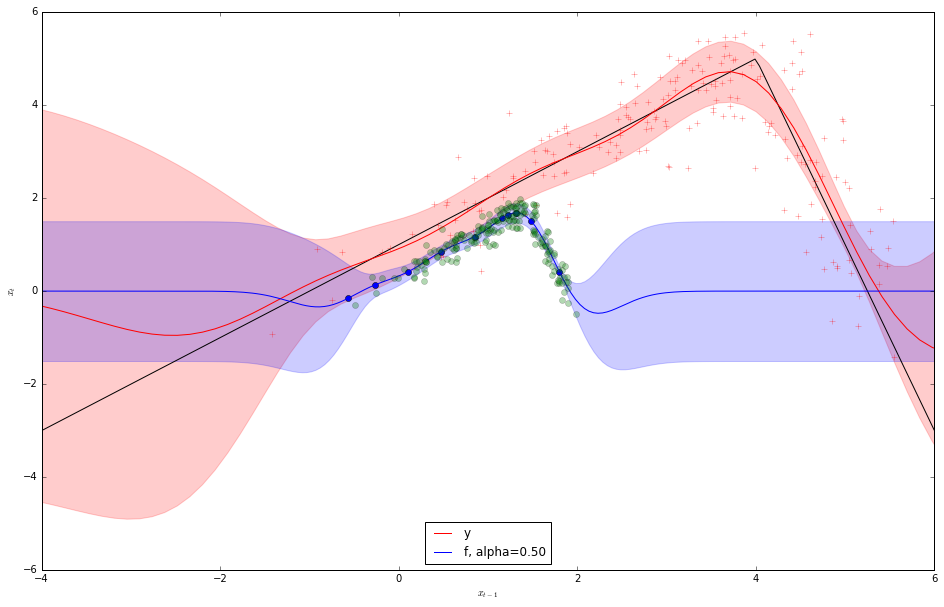

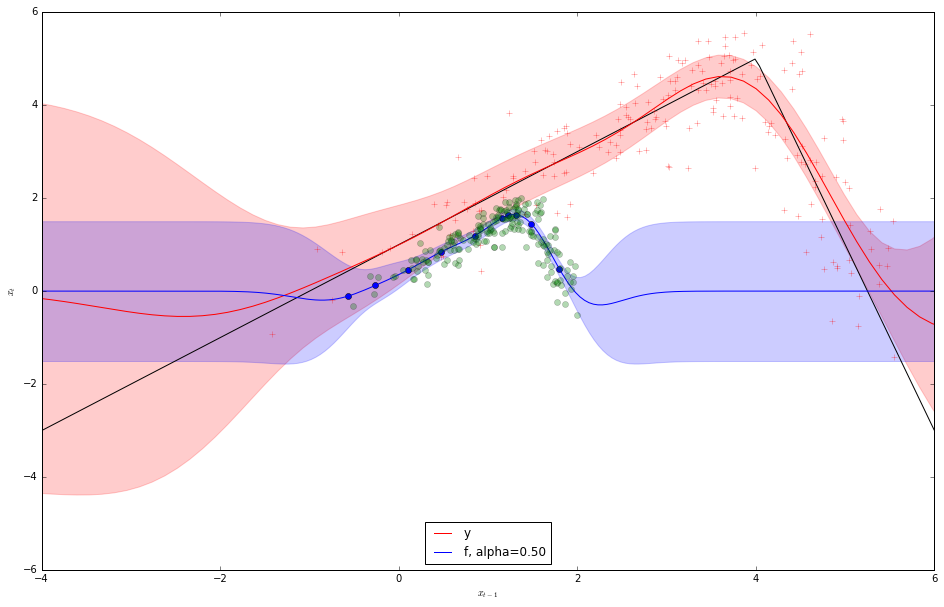

In [4]:
# create AEP model
model = aep.SGPSSM(y_train, Dlatent, M, 
    lik='Gaussian', prior_mean=0, prior_var=1000)
hypers = model.init_hypers(y_train)
for key in params.keys():
    hypers[key] = params[key]
model.update_hypers(hypers, alpha)
# optimise
model.optimise(method='L-BFGS-B', alpha=alpha, maxiter=3000, reinit_hypers=False)
opt_hypers = model.get_hypers()
plot(model)

# create EP model
model_ep = ep.SGPSSM(y_train, Dlatent, M, 
    lik='Gaussian', prior_mean=0, prior_var=1000)
model_ep.update_hypers(opt_hypers)
# run EP
model_ep.inference(no_epochs=50, alpha=alpha, parallel=True, decay=0.99)
plot(model_ep)

{   'C': array([[ 1.]]),
    'R': array([-2.46996169]),
    'ls': array([ 0.23046795]),
    'sf': array([ 0.80236024]),
    'sn': array(-0.3749728281956183),
    'zu': array([[-0.32018689],
       [-0.18772579],
       [-1.18131608],
       [ 0.82749893],
       [ 2.02312761],
       [ 3.44993358],
       [ 3.96151179],
       [ 2.97828706],
       [ 3.50751954],
       [ 5.12080175]])}
epoch 0/100
epoch 1/100
epoch 2/100
epoch 3/100
epoch 4/100
epoch 5/100
epoch 6/100
epoch 7/100
epoch 8/100
epoch 9/100
epoch 10/100
epoch 11/100
epoch 12/100
epoch 13/100
epoch 14/100
epoch 15/100
epoch 16/100
epoch 17/100
epoch 18/100
epoch 19/100
epoch 20/100
epoch 21/100
epoch 22/100
epoch 23/100
epoch 24/100
epoch 25/100
epoch 26/100
epoch 27/100
epoch 28/100
epoch 29/100
epoch 30/100
epoch 31/100
epoch 32/100
epoch 33/100
epoch 34/100
epoch 35/100
epoch 36/100
epoch 37/100
epoch 38/100
epoch 39/100
epoch 40/100
epoch 41/100
epoch 42/100
epoch 43/100
epoch 44/100
epoch 45/100
epoch 46/100
epoch 47/

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


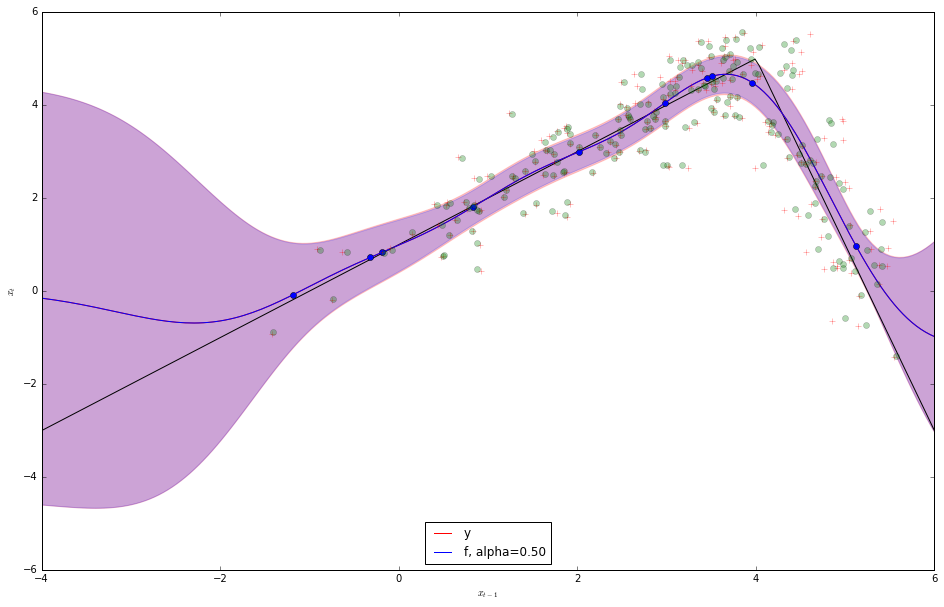

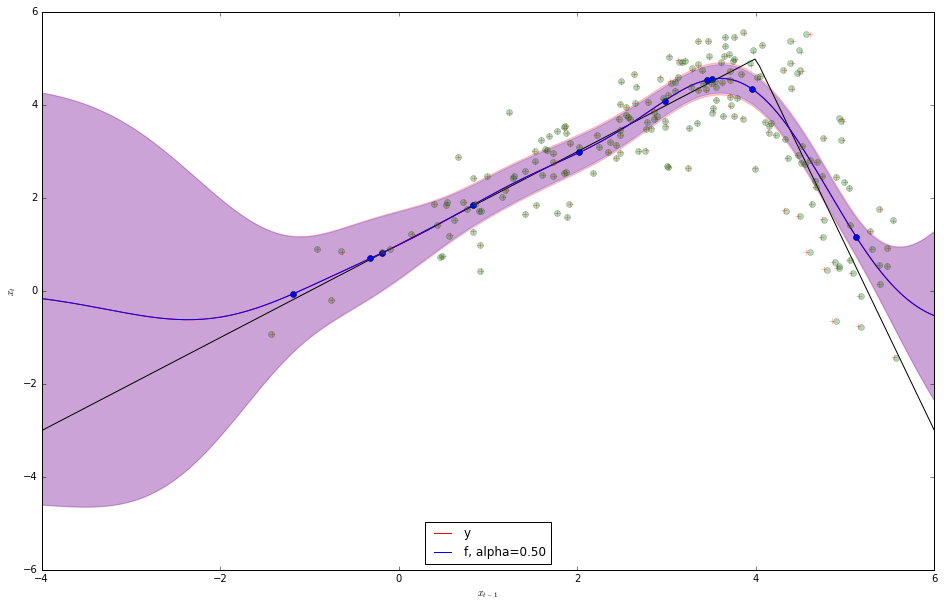

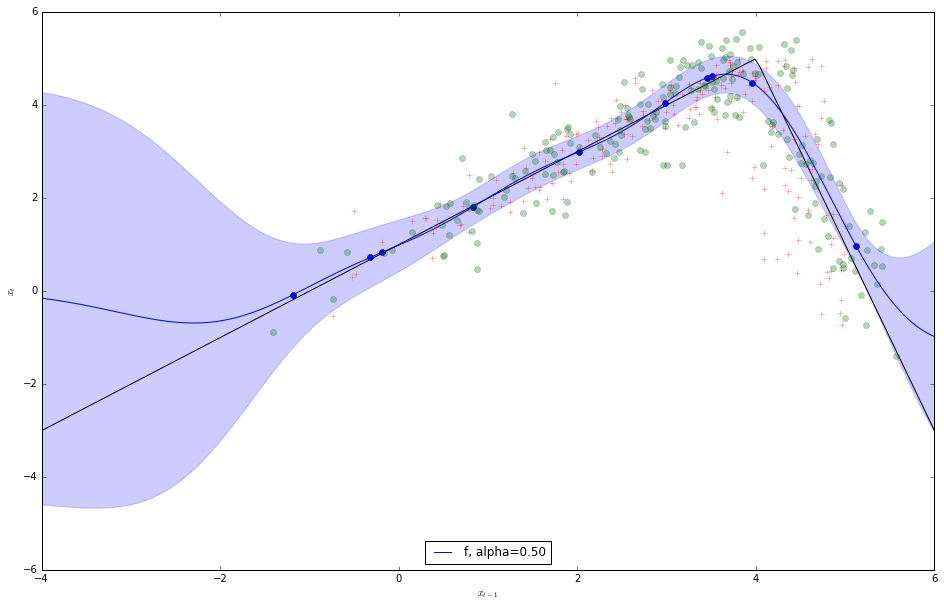

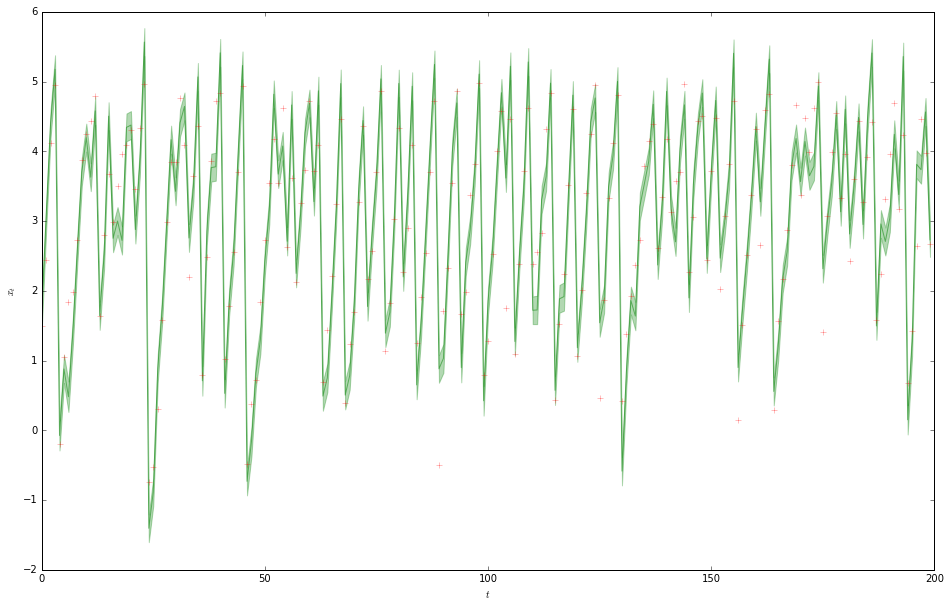

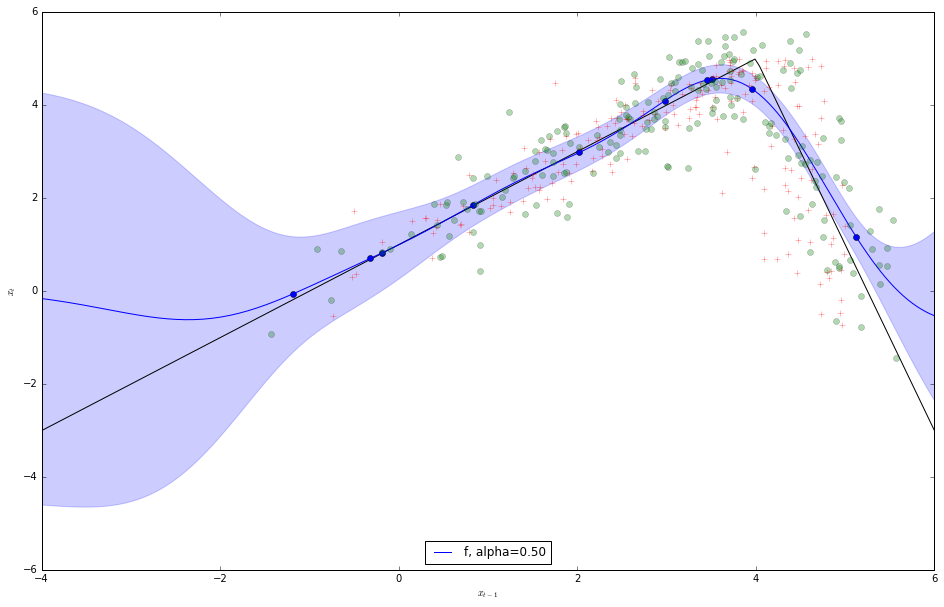

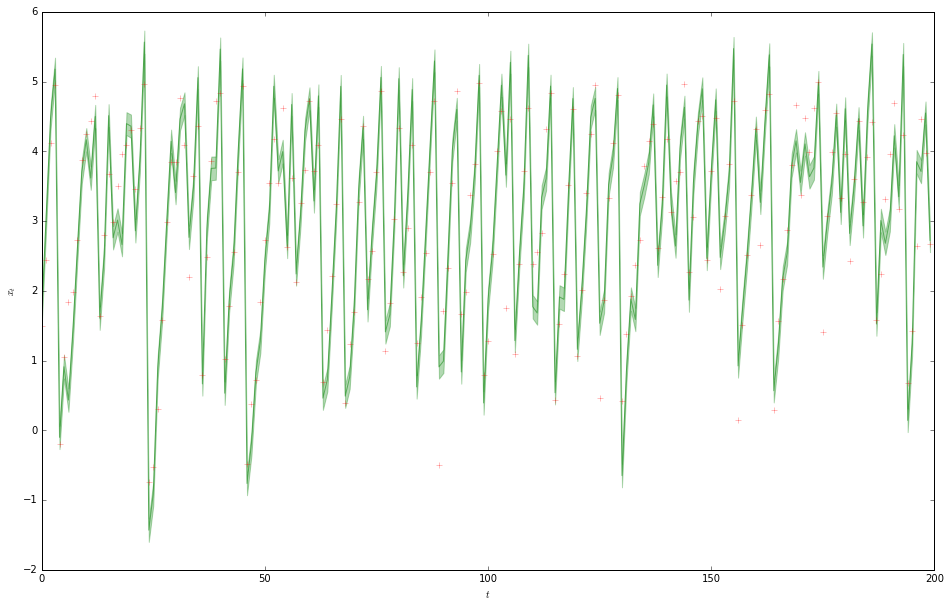

In [5]:
# create AEP model
model = aep.SGPSSM(y_train, Dlatent, M, 
    lik='Gaussian', prior_mean=0, prior_var=1000)
hypers = model.init_hypers(y_train)
for key in params.keys():
    hypers[key] = params[key]
model.update_hypers(hypers, alpha)
# optimise
model.set_fixed_params(['C'])
model.optimise(method='L-BFGS-B', alpha=alpha, maxiter=3000, reinit_hypers=False)
opt_hypers = model.get_hypers()
plot(model)
# create EP model
model_ep = ep.SGPSSM(y_train, Dlatent, M, 
    lik='Gaussian', prior_mean=0, prior_var=1000)
model_ep.update_hypers(opt_hypers)
# run EP
model_ep.inference(no_epochs=100, alpha=alpha, parallel=True, decay=0.99)
plot(model_ep)

plot_latent(model, xtrue)
plot_latent(model_ep, xtrue)